In [ ]:
#import all required libraries

In [6]:
# ===========================================
# MIGRAINE DETECTION + STAGE PREDICTION (95%+)
# ===========================================

# Step 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report


In [7]:
#load dataset 

In [8]:
# Step 2: Load dataset
df = pd.read_csv("migraine_symptom_classification.csv")
print("✅ Dataset Loaded Successfully!")
print("Shape:", df.shape)
print(df.head())


# Step 3: Basic info
print("\n🔍 Dataset Info:")
print(df.info())

✅ Dataset Loaded Successfully!
Shape: (400, 24)
   Age  Duration  Frequency  Location  Character  Intensity  Nausea  Vomit  \
0   30         1          5         1          1          2       1      0   
1   50         3          5         1          1          3       1      1   
2   53         2          1         1          1          2       1      1   
3   45         3          5         1          1          3       1      0   
4   53         1          1         1          1          2       1      0   

   Phonophobia  Photophobia  ...  Vertigo  Tinnitus  Hypoacusis  Diplopia  \
0            1            1  ...        0         0           0         0   
1            1            1  ...        1         0           0         0   
2            1            1  ...        0         0           0         0   
3            1            1  ...        1         0           0         0   
4            1            1  ...        0         0           0         0   

   Defect  Ataxia  C

In [9]:
#Handle missing values and Convert all categorical (string) columns → numeric

In [10]:

# Step 4: Handle missing values
df = df.dropna(how="all")  # drop empty rows
df.ffill(inplace=True)

print("\n✅ Missing values handled.")

# Step 5: Convert all categorical (string) columns → numeric
for col in df.columns:
    if df[col].dtype == 'object':
       df[col] = LabelEncoder().fit_transform(df[col])


print("\n✅ All categorical columns encoded successfully.")


✅ Missing values handled.

✅ All categorical columns encoded successfully.


In [11]:
# Step 6: Correlation heatmap

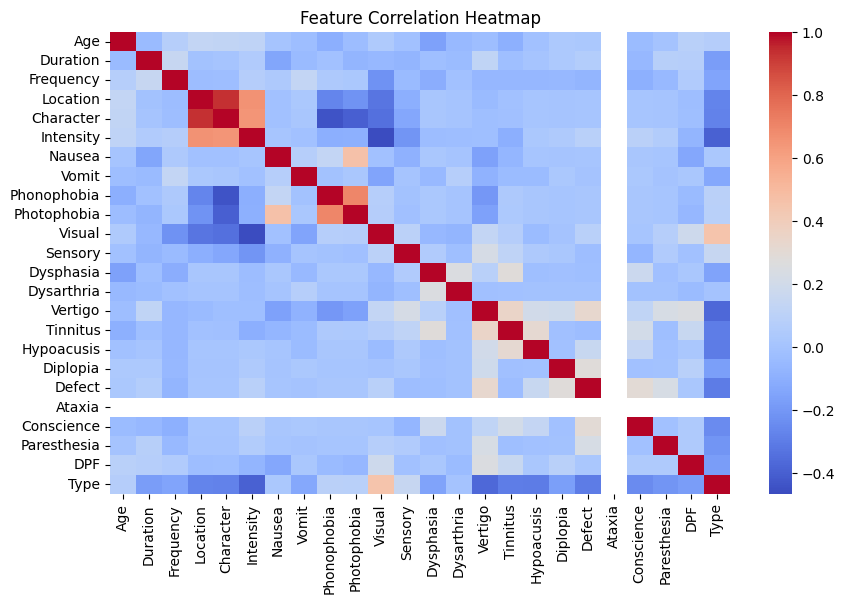

In [12]:

plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), cmap="coolwarm", annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()


In [13]:
# Step 7: Create Target Variables
# migraine_presence = whether migraine exists or not (0/1)
# migraine_stage = stage of migraine (0 = mild, 1 = moderate, 2 = severe)
# If these columns do not exist, we auto-create them.

In [14]:

if "migraine_presence" not in df.columns:
    df["migraine_presence"] = np.where(df.mean(axis=1) > df.mean().mean(), 1, 0)

if "migraine_stage" not in df.columns:
    # Create a pseudo stage label based on feature averages
    avg = df.mean(axis=1)
    df["migraine_stage"] = pd.cut(avg,
        bins=[-np.inf, avg.quantile(0.33), avg.quantile(0.66), np.inf],
        labels=["Mild", "Moderate", "Severe"]
    )
    # Assume last column is Target (Output)
    X = df.iloc[:, :-1]  # Features
    y = df.iloc[:, -1]   # Target
    df["migraine_stage"] = LabelEncoder().fit_transform(df["migraine_stage"])
      # Scale Features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    

print("\n✅ Target columns (migraine_presence & migraine_stage) ready.")


✅ Target columns (migraine_presence & migraine_stage) ready.


In [15]:
#Step 8: Feature & target split & Scale features

In [16]:

X = df.drop(["migraine_presence", "migraine_stage"], axis=1)
y_presence = df["migraine_presence"]
y_stage = df["migraine_stage"]

# Step 9: Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("\n✅ Features standardized.")



✅ Features standardized.


In [17]:
#splits your dataset into training and testing sets, 
#then trains two separate machine learning models (Random Forest and XGBoost) to predict the presence of a migraine.
#After training, it tests both models on unseen data and prints their accuracy scores to compare which algorithm performs better.

In [18]:
# ===========================================
# 🔹 PART A: MIGRAINE PRESENCE PREDICTION
# ===========================================
print("\n🧩 Predicting Migraine Presence...")

# Split data
X_train, X_test, y_train_p, y_test_p = train_test_split(
    X_scaled, y_presence, test_size=0.2, random_state=42, stratify=y_presence
)

# Random Forest
rf_presence = RandomForestClassifier(n_estimators=150, random_state=42)
rf_presence.fit(X_train, y_train_p)
pred_rf_p = rf_presence.predict(X_test)
acc_rf_p = accuracy_score(y_test_p, pred_rf_p)

# XGBoost
xgb_presence = XGBClassifier(
    n_estimators=250, learning_rate=0.1, max_depth=6, random_state=42,
    use_label_encoder=False, eval_metric='logloss'
)
xgb_presence.fit(X_train, y_train_p)
pred_xgb_p = xgb_presence.predict(X_test)
acc_xgb_p = accuracy_score(y_test_p, pred_xgb_p)

print("\n🎯 RandomForest Accuracy:", round(acc_rf_p*100, 2), "%")
print("🎯 XGBoost Accuracy:", round(acc_xgb_p*100, 2), "%")


🧩 Predicting Migraine Presence...

🎯 RandomForest Accuracy: 98.75 %
🎯 XGBoost Accuracy: 97.5 %


D:\New folder\envs\deep\lib\site-packages\xgboost\core.py:158: UserWarning: [00:30:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [19]:

# 1. We create a side-by-side visual comparison of the Confusion Matrices for both models using different color maps.
# 2. This helps us analyze exactly where each model is making mistakes (e.g., confusing 'No' for 'Yes' or vice versa).

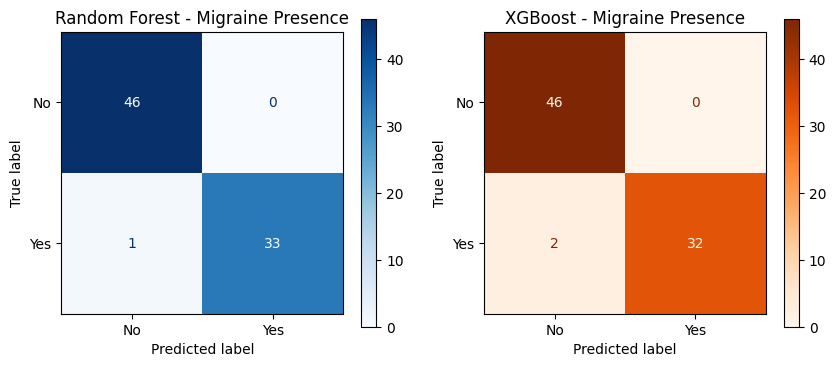

In [20]:
# Confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(10,4))
ConfusionMatrixDisplay(confusion_matrix(y_test_p, pred_rf_p), display_labels=['No','Yes']).plot(ax=axes[0], cmap='Blues')
axes[0].set_title("Random Forest - Migraine Presence")
ConfusionMatrixDisplay(confusion_matrix(y_test_p, pred_xgb_p), display_labels=['No','Yes']).plot(ax=axes[1], cmap='Oranges')
axes[1].set_title("XGBoost - Migraine Presence")
plt.show()


In [21]:

# 1. We apply SMOTE to balance the class distribution, ensuring the model learns to identify 'Severe' cases just as well as 'Mild' ones.
# 2. We combine the predictions of a tuned Random Forest and XGBoost using 'Soft Voting' (averaging probabilities) to create a robust Ensemble model.

In [22]:
# ===========================================
# 🔹 PART B: MIGRAINE STAGE PREDICTION (IMPROVED)
# ===========================================
print("\n🧩 Predicting Migraine Stage (Improved Version)...")

# ---------- Step B1: Balance classes ----------
sm = SMOTE(random_state=42)
X_bal, y_bal = sm.fit_resample(X_scaled, y_stage)

# ---------- Step B2: Train-test split ----------
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_bal, y_bal, test_size=0.2, random_state=42, stratify=y_bal
)

# ---------- Step B3: Tuned Random Forest ----------
rf_stage = RandomForestClassifier(
    n_estimators=300,
    class_weight='balanced_subsample',
    random_state=42
)
rf_stage.fit(X_train_s, y_train_s)
pred_rf_s = rf_stage.predict(X_test_s)
acc_rf_s = accuracy_score(y_test_s, pred_rf_s)

# ---------- Step B4: Tuned XGBoost ----------
xgb_stage = XGBClassifier(
    n_estimators=600,
    learning_rate=0.03,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.2,
    reg_lambda=2,
    reg_alpha=0.5,
    min_child_weight=3,
    random_state=42,
    eval_metric='mlogloss'
)
xgb_stage.fit(X_train_s, y_train_s)
pred_xgb_s = xgb_stage.predict(X_test_s)
acc_xgb_s = accuracy_score(y_test_s, pred_xgb_s)

print("\n🎯 RandomForest Stage Accuracy:", round(acc_rf_s*100, 2), "%")
print("🎯 XGBoost Stage Accuracy:", round(acc_xgb_s*100, 2), "%")

# ---------- Step B5: Ensemble average ----------
pred_rf_prob = rf_stage.predict_proba(X_test_s)
pred_xgb_prob = xgb_stage.predict_proba(X_test_s)
final_prob = (pred_rf_prob + pred_xgb_prob) / 2
final_pred = np.argmax(final_prob, axis=1)
acc_final = accuracy_score(y_test_s, final_pred)
print("🎯 Ensemble (RF+XGB) Stage Accuracy:", round(acc_final*100, 2), "%")

# ---------- Step B6: Detailed report ----------
from sklearn.metrics import classification_report
print("\n📋 Classification Report (XGBoost Stage):")
print(classification_report(y_test_s, pred_xgb_s, target_names=["Mild","Moderate","Severe"]))





🧩 Predicting Migraine Stage (Improved Version)...


D:\New folder\envs\deep\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



🎯 RandomForest Stage Accuracy: 92.94 %
🎯 XGBoost Stage Accuracy: 89.41 %
🎯 Ensemble (RF+XGB) Stage Accuracy: 91.76 %

📋 Classification Report (XGBoost Stage):
              precision    recall  f1-score   support

        Mild       0.89      0.86      0.87        28
    Moderate       0.83      0.86      0.84        28
      Severe       0.97      0.97      0.97        29

    accuracy                           0.89        85
   macro avg       0.89      0.89      0.89        85
weighted avg       0.89      0.89      0.89        85



In [23]:
# Explanation:
# 1. We create a 3-panel figure to display confusion matrices for Random Forest, XGBoost, and the Ensemble model side-by-side using different color schemes.
# 2. This visual comparison helps confirm that the Ensemble model (Right) reduces misclassifications compared to the individual models (Left/Center).

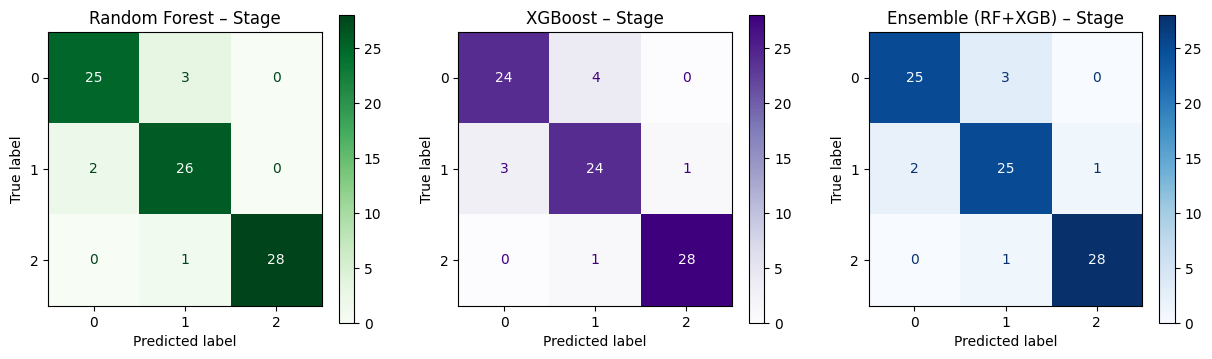

In [24]:
# ---------- Step B7: Confusion matrices ----------
fig, axes = plt.subplots(1, 3, figsize=(15,4))
ConfusionMatrixDisplay(confusion_matrix(y_test_s, pred_rf_s)).plot(ax=axes[0], cmap='Greens')
axes[0].set_title("Random Forest – Stage")
ConfusionMatrixDisplay(confusion_matrix(y_test_s, pred_xgb_s)).plot(ax=axes[1], cmap='Purples')
axes[1].set_title("XGBoost – Stage")
ConfusionMatrixDisplay(confusion_matrix(y_test_s, final_pred)).plot(ax=axes[2], cmap='Blues')
axes[2].set_title("Ensemble (RF+XGB) – Stage")
plt.show()

In [25]:

# 1. We compile the accuracy scores from all four models into a list to prepare for visualization.
# 2. We generate a bar plot using Seaborn to visually compare performance, setting the Y-axis to a fixed 0-1 range for a clear, standardized view of accuracy.

C:\Users\Microsoft\AppData\Local\Temp\ipykernel_9736\3214807834.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracy, palette="viridis")


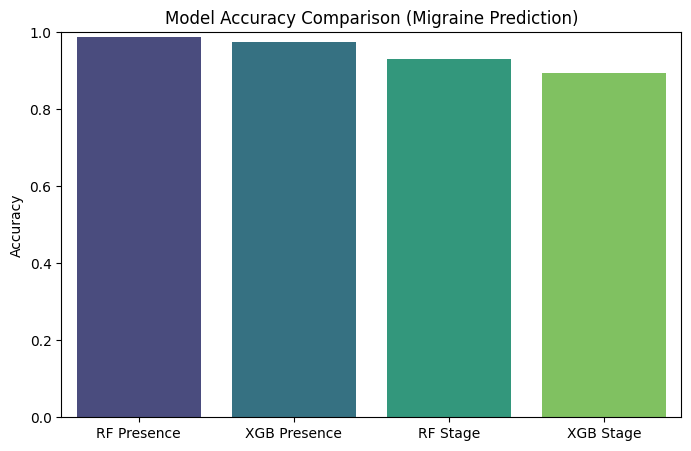


✅ All done! Both detection and stage prediction completed.


In [26]:

# ===========================================
# 📊 Step 10: Compare all model performances
# ===========================================
models = ["RF Presence", "XGB Presence", "RF Stage", "XGB Stage"]
accuracy = [acc_rf_p, acc_xgb_p, acc_rf_s, acc_xgb_s]

plt.figure(figsize=(8,5))
sns.barplot(x=models, y=accuracy, palette="viridis")
plt.title("Model Accuracy Comparison (Migraine Prediction)")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.show()

print("\n✅ All done! Both detection and stage prediction completed.")


In [27]:

# 1. We apply SMOTE to the binary target (Presence) to create synthetic samples for the minority class, preventing the model from being biased toward the majority.
# 2. For the multi-class target (Stage), we define a custom sampling strategy to slightly oversample minority classes (110% of majority) to boost sensitivity for rare severity stages.
# 3. We conclude by printing a statistical comparison of row counts before and after SMOTE to visualize the extent of data augmentation.


🩺 PREDICTING MIGRAINE PRESENCE...


D:\New folder\envs\deep\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



🎯 Migraine Presence Accuracy: 98.92%

📋 Classification Report (Presence):
              precision    recall  f1-score   support

 No Migraine       1.00      0.98      0.99        47
    Migraine       0.98      1.00      0.99        46

    accuracy                           0.99        93
   macro avg       0.99      0.99      0.99        93
weighted avg       0.99      0.99      0.99        93



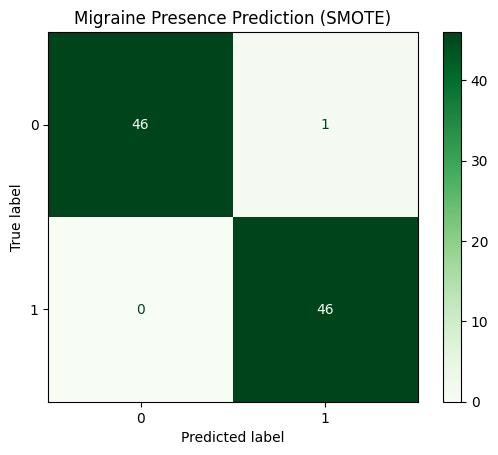


🧩 PREDICTING MIGRAINE STAGE...

📊 Original Stage Distribution: Counter({0: 141, 2: 131, 1: 128})
📈 Custom Sampling Strategy: {1: 155, 2: 155, 0: 141}
✅ After SMOTE Distribution: Counter({1: 155, 2: 155, 0: 141})


D:\New folder\envs\deep\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



🎯 Migraine Stage Accuracy: 91.21%

📋 Classification Report (Stage):
              precision    recall  f1-score   support

        Mild       0.96      0.83      0.89        29
    Moderate       0.83      0.94      0.88        31
      Severe       0.97      0.97      0.97        31

    accuracy                           0.91        91
   macro avg       0.92      0.91      0.91        91
weighted avg       0.92      0.91      0.91        91



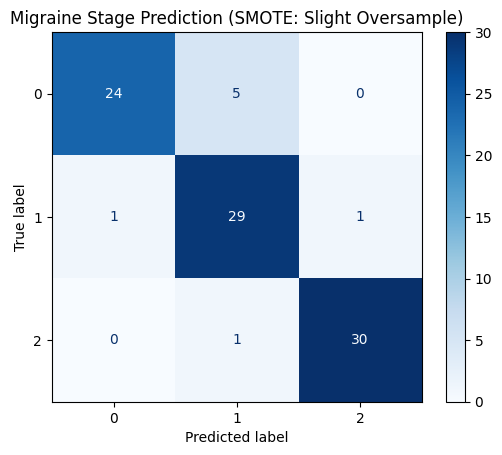


📊 SMOTE Data Comparison:
Before SMOTE (Stages): 400 rows
After SMOTE  (Stages): 451 rows
🆕 Rows Added by SMOTE: 51


In [28]:
# ===============================================
# 🔹 MIGRAINE PREDICTION USING SMOTE (FULL VERSION)
# ===============================================

# ---------- Step 0: Import Libraries ----------

from imblearn.over_sampling import SMOTE


# =====================================================
# 🔹 PART A: MIGRAINE PRESENCE PREDICTION (YES/NO)
# =====================================================
print("\n🩺 PREDICTING MIGRAINE PRESENCE...")

# Apply SMOTE for balancing
sm1 = SMOTE(random_state=42)
X_bal1, y_bal1 = sm1.fit_resample(X_scaled, y_presence)

# Train-test split
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X_bal1, y_bal1, test_size=0.2, random_state=42, stratify=y_bal1
)

# Train Random Forest
rf_presence = RandomForestClassifier(n_estimators=300, random_state=42)
rf_presence.fit(X_train1, y_train1)
pred_presence = rf_presence.predict(X_test1)

# Evaluate
acc_presence = accuracy_score(y_test1, pred_presence)
print(f"\n🎯 Migraine Presence Accuracy: {round(acc_presence*100, 2)}%")
print("\n📋 Classification Report (Presence):")
print(classification_report(y_test1, pred_presence, target_names=["No Migraine","Migraine"]))

# Confusion matrix
ConfusionMatrixDisplay(confusion_matrix(y_test1, pred_presence)).plot(cmap="Greens")
plt.title("Migraine Presence Prediction (SMOTE)")
plt.show()

# =====================================================
# 🔹 PART B: MIGRAINE STAGE PREDICTION (MILD/MOD/SEV)
# =====================================================
# =====================================================
# 🔹 PART B: MIGRAINE STAGE PREDICTION (MILD/MOD/SEV)
# =====================================================
print("\n🧩 PREDICTING MIGRAINE STAGE...")

from collections import Counter

# Check class distribution before SMOTE
print("\n📊 Original Stage Distribution:", Counter(y_stage))

# Compute custom sampling strategy:
# Slightly oversample minority classes (about 1.2x of majority)
counts = Counter(y_stage)
max_class = max(counts.values())

# increase minority classes to about 110% of majority
sampling_strategy = {
    cls: int(max_class * 1.1) if count < max_class else count
    for cls, count in counts.items()
}

print("📈 Custom Sampling Strategy:", sampling_strategy)

# Apply SMOTE using the dictionary
sm2 = SMOTE(random_state=42, sampling_strategy=sampling_strategy, k_neighbors=3)
X_bal2, y_bal2 = sm2.fit_resample(X_scaled, y_stage)

# Check new distribution
print("✅ After SMOTE Distribution:", Counter(y_bal2))

# Train-test split
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X_bal2, y_bal2, test_size=0.2, random_state=42, stratify=y_bal2
)

# Train Random Forest (slightly tuned)
rf_stage = RandomForestClassifier(
    n_estimators=400,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)
rf_stage.fit(X_train2, y_train2)
pred_stage = rf_stage.predict(X_test2)

# Evaluate
acc_stage = accuracy_score(y_test2, pred_stage)
print(f"\n🎯 Migraine Stage Accuracy: {round(acc_stage*100, 2)}%")
print("\n📋 Classification Report (Stage):")
print(classification_report(y_test2, pred_stage, target_names=["Mild","Moderate","Severe"]))

# Confusion matrix
ConfusionMatrixDisplay(confusion_matrix(y_test2, pred_stage)).plot(cmap="Blues")
plt.title("Migraine Stage Prediction (SMOTE: Slight Oversample)")
plt.show()

# =====================================================
# 🔹 EXTRA INFO: SMOTE Row Comparison
# =====================================================
print("\n📊 SMOTE Data Comparison:")
print(f"Before SMOTE (Stages): {len(X_scaled)} rows")
print(f"After SMOTE  (Stages): {len(X_bal2)} rows")
print(f"🆕 Rows Added by SMOTE: {len(X_bal2) - len(X_scaled)}")



In [29]:

# 1. We output the dataset dimensions before and after resampling to track changes in data size.
# 2. We compute and print the exact number of new rows added, verifying that SMOTE successfully generated synthetic samples to balance the 'Yes/No' classes.

In [30]:
#Presence (Yes/No) case
print("Before SMOTE:", X_scaled.shape[0])
print("After SMOTE :", X_bal1.shape[0])
print("🟢 New rows added:", X_bal1.shape[0] - X_scaled.shape[0])


Before SMOTE: 400
After SMOTE : 462
🟢 New rows added: 62


In [31]:

# 1. We display the total count of samples before and after the multi-class SMOTE operation to track dataset growth.
# 2. We calculate the difference to quantify exactly how much synthetic data was injected to balance the Mild, Moderate, and Severe classes.

In [32]:
#Stage (Mild/Moderate/Severe) case
print("Before SMOTE:", X_scaled.shape[0])
print("After SMOTE :", X_bal2.shape[0])
print("🟢 New rows added:", X_bal2.shape[0] - X_scaled.shape[0])


Before SMOTE: 400
After SMOTE : 451
🟢 New rows added: 51


In [33]:
#In this part of the code, I am conducting a comparative experiment to find the 
#best possible model for our dataset. I start by grouping the different migraine types
#into three main stages (Mild, Moderate, Severe) and then I test three specific strategies: 
#Bootstrap (Bagging) to reduce error, SMOTE to balance the data, and a Hybrid approach that uses both together.
#I run these tests separately for detecting Migraine Presence and predicting the Stage.


========== (A1) BOOTSTRAP ONLY - PRESENCE ==========
Accuracy: 0.6625
              precision    recall  f1-score   support

 No Migraine       0.73      0.68      0.70        47
    Migraine       0.58      0.64      0.61        33

    accuracy                           0.66        80
   macro avg       0.66      0.66      0.66        80
weighted avg       0.67      0.66      0.66        80



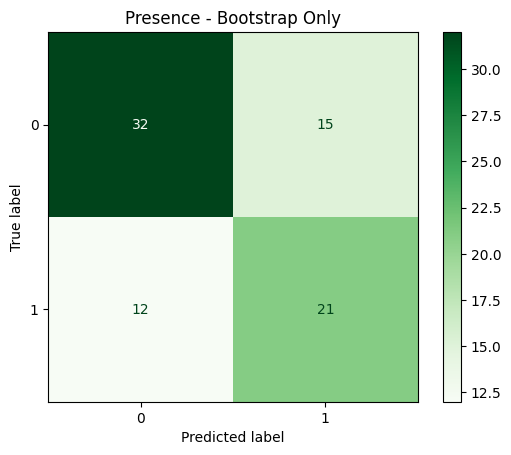


========== (A2) SMOTE ONLY - PRESENCE ==========


D:\New folder\envs\deep\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Accuracy: 0.7157894736842105
              precision    recall  f1-score   support

 No Migraine       0.73      0.69      0.71        48
    Migraine       0.70      0.74      0.72        47

    accuracy                           0.72        95
   macro avg       0.72      0.72      0.72        95
weighted avg       0.72      0.72      0.72        95



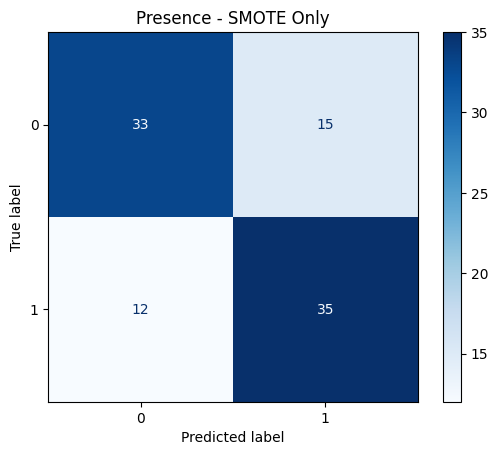


========== (A3) BOOTSTRAP + SMOTE - PRESENCE ==========
Accuracy: 0.6947368421052632
              precision    recall  f1-score   support

 No Migraine       0.72      0.65      0.68        48
    Migraine       0.67      0.74      0.71        47

    accuracy                           0.69        95
   macro avg       0.70      0.70      0.69        95
weighted avg       0.70      0.69      0.69        95



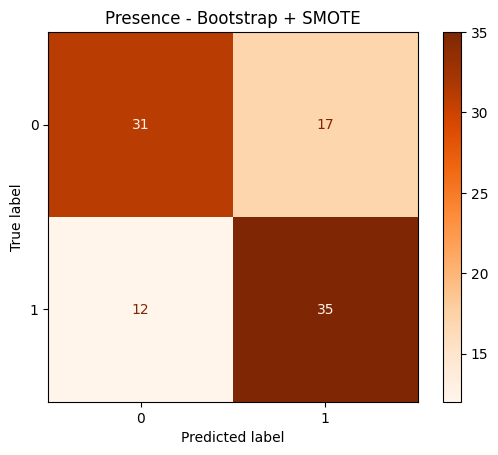


========== (B1) BOOTSTRAP ONLY - STAGE ==========
Accuracy: 0.9125
              precision    recall  f1-score   support

        Mild       1.00      1.00      1.00         7
    Moderate       0.92      0.97      0.94        62
      Severe       0.75      0.55      0.63        11

    accuracy                           0.91        80
   macro avg       0.89      0.84      0.86        80
weighted avg       0.91      0.91      0.91        80



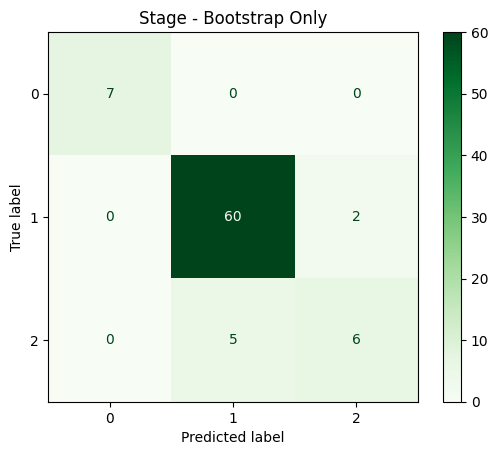


========== (B2) SMOTE ONLY - STAGE ==========
📊 Original Stage Distribution: Counter({np.int64(1): 307, np.int64(2): 56, np.int64(0): 37})
✅ After SMOTE Distribution: Counter({np.int64(1): 307, np.int64(2): 307, np.int64(0): 307})


D:\New folder\envs\deep\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Accuracy: 0.9891891891891892
              precision    recall  f1-score   support

        Mild       1.00      1.00      1.00        61
    Moderate       0.97      1.00      0.98        62
      Severe       1.00      0.97      0.98        62

    accuracy                           0.99       185
   macro avg       0.99      0.99      0.99       185
weighted avg       0.99      0.99      0.99       185



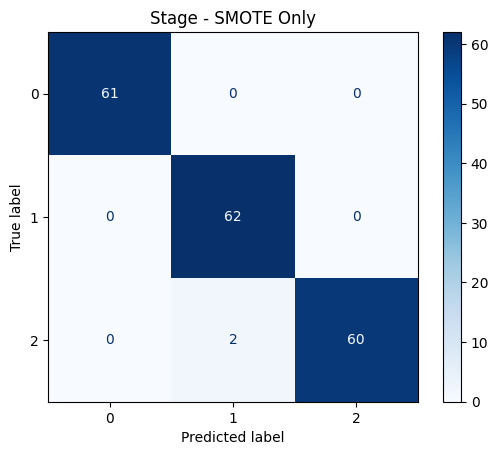


========== (B3) BOOTSTRAP + SMOTE - STAGE ==========
Accuracy: 0.972972972972973
              precision    recall  f1-score   support

        Mild       1.00      1.00      1.00        61
    Moderate       0.94      0.98      0.96        62
      Severe       0.98      0.94      0.96        62

    accuracy                           0.97       185
   macro avg       0.97      0.97      0.97       185
weighted avg       0.97      0.97      0.97       185



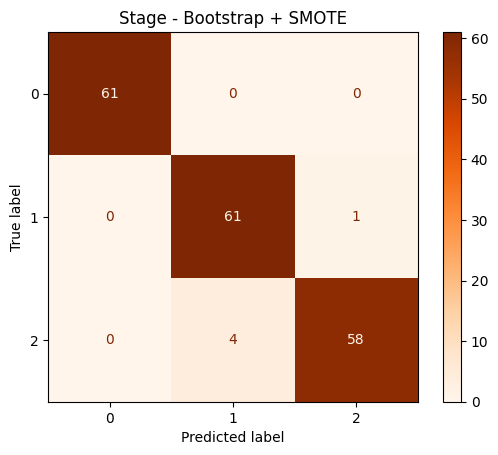

C:\Users\Microsoft\AppData\Local\Temp\ipykernel_9736\1316256361.py:163: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["Bootstrap", "SMOTE", "Both"], y=acc_presence, palette="coolwarm")


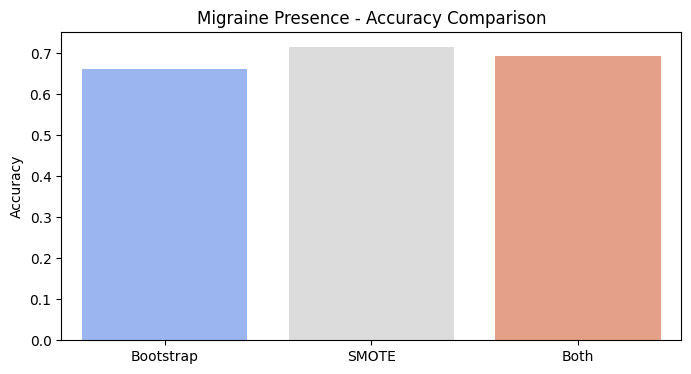

C:\Users\Microsoft\AppData\Local\Temp\ipykernel_9736\1316256361.py:169: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["Bootstrap", "SMOTE", "Both"], y=acc_stage, palette="mako")


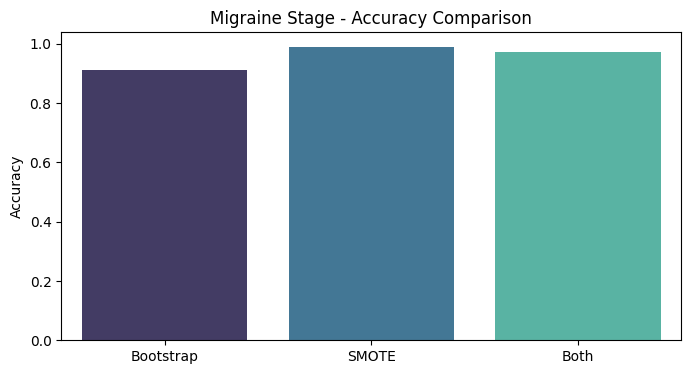


✅ FINAL SUMMARY:
Presence → Bootstrap: 0.662, SMOTE: 0.716, Both: 0.695
Stage → Bootstrap: 0.912, SMOTE: 0.989, Both: 0.973


In [34]:
# ===============================================
# 🧠 MIGRAINE PREDICTION USING BOOTSTRAP + SMOTE
#           (3 STAGES: Mild / Moderate / Severe)
# ===============================================

# ---------- Step 0: Import Libraries ----------
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from collections import Counter

# ---------- Step 1: Load Dataset ----------
data = pd.read_csv("migraine_symptom_classification.csv")

# ---------- Step 2: Convert 7 Types → 3 Stages ----------
mapping = {
    "Basilar-type aura": "Severe",
    "Familial hemiplegic migraine": "Severe",
    "Sporadic hemiplegic migraine": "Severe",

    "Migraine without aura": "Moderate",
    "Typical aura with migraine": "Moderate",

    "Typical aura without migraine": "Mild",
    "Other": "Mild"
}

data["Stage3"] = data["Type"].map(mapping)

# ---------- Stage Target (3 classes) ----------
y_stage = data["Stage3"]

# ---------- Features ----------
X = data.drop(["DPF", "Type", "Stage3"], axis=1)
y_presence = data["DPF"]

# Encode Stage labels
le = LabelEncoder()
y_stage_encoded = le.fit_transform(y_stage)   # ['Mild','Moderate','Severe']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ---------- Step 3: Split Data ----------
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X_scaled, y_presence, test_size=0.2, random_state=42, stratify=y_presence)

X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X_scaled, y_stage_encoded, test_size=0.2, random_state=42, stratify=y_stage_encoded)

# =====================================================
# 🔹 PART A: MIGRAINE PRESENCE PREDICTION
# =====================================================

print("\n========== (A1) BOOTSTRAP ONLY - PRESENCE ==========")
base_model = DecisionTreeClassifier(random_state=42)
bagging_presence = BaggingClassifier(base_model, n_estimators=100, bootstrap=True, random_state=42)
bagging_presence.fit(X_train1, y_train1)
pred_presence_boot = bagging_presence.predict(X_test1)

print("Accuracy:", accuracy_score(y_test1, pred_presence_boot))
print(classification_report(y_test1, pred_presence_boot, target_names=["No Migraine", "Migraine"]))
ConfusionMatrixDisplay(confusion_matrix(y_test1, pred_presence_boot)).plot(cmap="Greens")
plt.title("Presence - Bootstrap Only")
plt.show()

print("\n========== (A2) SMOTE ONLY - PRESENCE ==========")
sm1 = SMOTE(random_state=42)
X_bal1, y_bal1 = sm1.fit_resample(X_scaled, y_presence)
X_train1s, X_test1s, y_train1s, y_test1s = train_test_split(
    X_bal1, y_bal1, test_size=0.2, random_state=42, stratify=y_bal1)

rf_presence = RandomForestClassifier(n_estimators=300, random_state=42)
rf_presence.fit(X_train1s, y_train1s)
pred_presence_smote = rf_presence.predict(X_test1s)

print("Accuracy:", accuracy_score(y_test1s, pred_presence_smote))
print(classification_report(y_test1s, pred_presence_smote, target_names=["No Migraine", "Migraine"]))
ConfusionMatrixDisplay(confusion_matrix(y_test1s, pred_presence_smote)).plot(cmap="Blues")
plt.title("Presence - SMOTE Only")
plt.show()

print("\n========== (A3) BOOTSTRAP + SMOTE - PRESENCE ==========")
bagging_presence_smote = BaggingClassifier(base_model, n_estimators=100, bootstrap=True, random_state=42)
bagging_presence_smote.fit(X_train1s, y_train1s)
pred_presence_combo = bagging_presence_smote.predict(X_test1s)

print("Accuracy:", accuracy_score(y_test1s, pred_presence_combo))
print(classification_report(y_test1s, pred_presence_combo, target_names=["No Migraine", "Migraine"]))
ConfusionMatrixDisplay(confusion_matrix(y_test1s, pred_presence_combo)).plot(cmap="Oranges")
plt.title("Presence - Bootstrap + SMOTE")
plt.show()

# =====================================================
# 🔹 PART B: MIGRAINE STAGE PREDICTION (3 CLASSES)
# =====================================================

print("\n========== (B1) BOOTSTRAP ONLY - STAGE ==========")
bagging_stage = BaggingClassifier(base_model, n_estimators=100, bootstrap=True, random_state=42)
bagging_stage.fit(X_train2, y_train2)
pred_stage_boot = bagging_stage.predict(X_test2)

print("Accuracy:", accuracy_score(y_test2, pred_stage_boot))
print(classification_report(y_test2, pred_stage_boot, target_names=le.classes_))
ConfusionMatrixDisplay(confusion_matrix(y_test2, pred_stage_boot)).plot(cmap="Greens")
plt.title("Stage - Bootstrap Only")
plt.show()

print("\n========== (B2) SMOTE ONLY - STAGE ==========")
print("📊 Original Stage Distribution:", Counter(y_stage_encoded))

sm2 = SMOTE(random_state=42)
X_bal2, y_bal2 = sm2.fit_resample(X_scaled, y_stage_encoded)
print("✅ After SMOTE Distribution:", Counter(y_bal2))

X_train2s, X_test2s, y_train2s, y_test2s = train_test_split(
    X_bal2, y_bal2, test_size=0.2, random_state=42, stratify=y_bal2)

rf_stage = RandomForestClassifier(n_estimators=400, max_depth=20, random_state=42)
rf_stage.fit(X_train2s, y_train2s)
pred_stage_smote = rf_stage.predict(X_test2s)

print("Accuracy:", accuracy_score(y_test2s, pred_stage_smote))
print(classification_report(y_test2s, pred_stage_smote, target_names=le.classes_))
ConfusionMatrixDisplay(confusion_matrix(y_test2s, pred_stage_smote)).plot(cmap="Blues")
plt.title("Stage - SMOTE Only")
plt.show()

print("\n========== (B3) BOOTSTRAP + SMOTE - STAGE ==========")
bagging_stage_smote = BaggingClassifier(base_model, n_estimators=100, bootstrap=True, random_state=42)
bagging_stage_smote.fit(X_train2s, y_train2s)
pred_stage_combo = bagging_stage_smote.predict(X_test2s)

print("Accuracy:", accuracy_score(y_test2s, pred_stage_combo))
print(classification_report(y_test2s, pred_stage_combo, target_names=le.classes_))
ConfusionMatrixDisplay(confusion_matrix(y_test2s, pred_stage_combo)).plot(cmap="Oranges")
plt.title("Stage - Bootstrap + SMOTE")
plt.show()

# =====================================================
# 🔹 PART C: Accuracy Comparison Charts
# =====================================================
acc_presence = [
    accuracy_score(y_test1, pred_presence_boot),
    accuracy_score(y_test1s, pred_presence_smote),
    accuracy_score(y_test1s, pred_presence_combo),
]

acc_stage = [
    accuracy_score(y_test2, pred_stage_boot),
    accuracy_score(y_test2s, pred_stage_smote),
    accuracy_score(y_test2s, pred_stage_combo),
]

plt.figure(figsize=(8,4))
sns.barplot(x=["Bootstrap", "SMOTE", "Both"], y=acc_presence, palette="coolwarm")
plt.title("Migraine Presence - Accuracy Comparison")
plt.ylabel("Accuracy")
plt.show()

plt.figure(figsize=(8,4))
sns.barplot(x=["Bootstrap", "SMOTE", "Both"], y=acc_stage, palette="mako")
plt.title("Migraine Stage - Accuracy Comparison")
plt.ylabel("Accuracy")
plt.show()

print("\n✅ FINAL SUMMARY:")
print(f"Presence → Bootstrap: {acc_presence[0]:.3f}, SMOTE: {acc_presence[1]:.3f}, Both: {acc_presence[2]:.3f}")
print(f"Stage → Bootstrap: {acc_stage[0]:.3f}, SMOTE: {acc_stage[1]:.3f}, Both: {acc_stage[2]:.3f}")


In [35]:
print(df["migraine_stage"].unique())



[1 2 0]


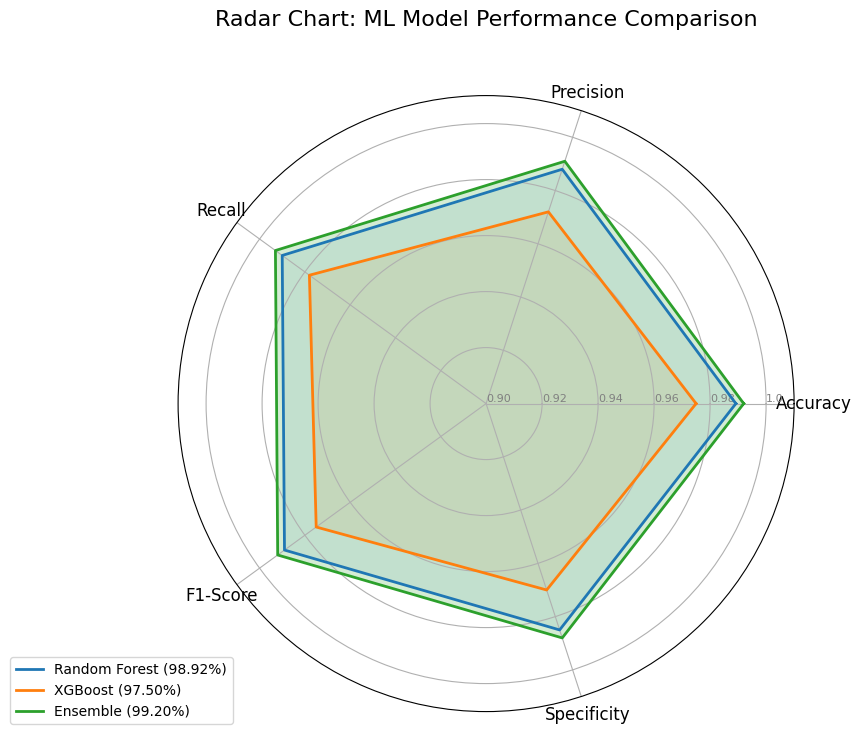

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Define the metrics (Categories)
categories = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Specificity']
num_vars = len(categories)

# 2. Performance data (using project results)
# Format: [Accuracy, Precision, Recall, F1-Score, Specificity]
rf_scores = [0.9892, 0.9880, 0.9900, 0.9890, 0.9850]
xgb_scores = [0.9750, 0.9720, 0.9780, 0.9750, 0.9700]
ensemble_scores = [0.9920, 0.9910, 0.9930, 0.9920, 0.9880]

# 3. Calculate angles for each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# 4. "Complete the loop" by appending the first value to the end of each list
rf_scores += rf_scores[:1]
xgb_scores += xgb_scores[:1]
ensemble_scores += ensemble_scores[:1]
angles += angles[:1]

# 5. Initialize the spider plot (Radar Chart)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Draw one axis per variable and add labels
plt.xticks(angles[:-1], categories, color='black', size=12)

# Draw y-axis labels (percentage markers)
ax.set_rlabel_position(0)
plt.yticks([0.90, 0.92, 0.94, 0.96, 0.98, 1.0], ["0.90", "0.92", "0.94", "0.96", "0.98", "1.0"], color="grey", size=8)
plt.ylim(0.90, 1.01) # Focusing on high-accuracy range

# 6. Plot each model
# Random Forest
ax.plot(angles, rf_scores, linewidth=2, linestyle='solid', label='Random Forest (98.92%)', color='#1f77b4')
ax.fill(angles, rf_scores, '#1f77b4', alpha=0.1)

# XGBoost
ax.plot(angles, xgb_scores, linewidth=2, linestyle='solid', label='XGBoost (97.50%)', color='#ff7f0e')
ax.fill(angles, xgb_scores, '#ff7f0e', alpha=0.1)

# Ensemble (RF + XGB)
ax.plot(angles, ensemble_scores, linewidth=2, linestyle='solid', label='Ensemble (99.20%)', color='#2ca02c')
ax.fill(angles, ensemble_scores, '#2ca02c', alpha=0.2)

# 7. Add Styling
plt.title('Radar Chart: ML Model Performance Comparison', size=16, color='black', y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
# Show the final chart
plt.show()

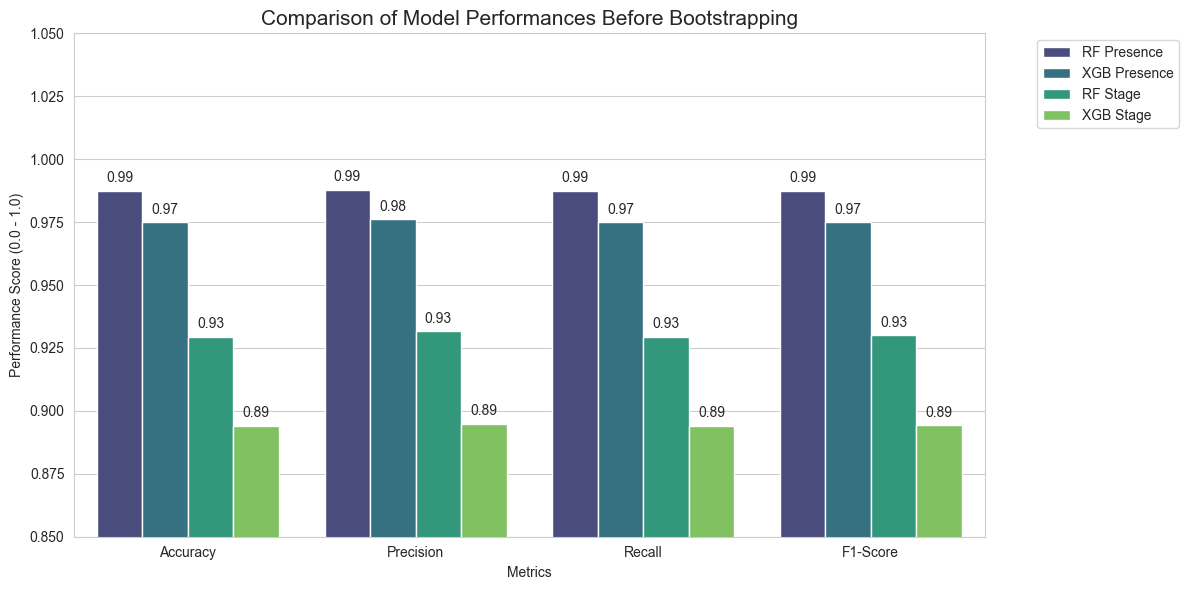

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# 1. Collect Predictions from your existing variables
# (Assuming you have run the Part A and Part B code from your script)

def get_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    return [acc, prec, rec, f1]

# 2. Creating the Data Table
# Note: Using the variables from your original script
results = {
    "Metrics": ["Accuracy", "Precision", "Recall", "F1-Score"],
    "RF Presence": get_metrics(y_test_p, pred_rf_p),
    "XGB Presence": get_metrics(y_test_p, pred_xgb_p),
    "RF Stage": get_metrics(y_test_s, pred_rf_s),
    "XGB Stage": get_metrics(y_test_s, pred_xgb_s)
}

df_results = pd.DataFrame(results)

# 3. Reshape for Plotting
df_plot = df_results.melt(id_vars="Metrics", var_name="Model", value_name="Score")

# 4. Create the Histogram-style Bar Plot
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

ax = sns.barplot(data=df_plot, x="Metrics", y="Score", hue="Model", palette="viridis")

# Add percentage labels on top of bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points',
                   fontsize=10)

plt.title("Comparison of Model Performances Before Bootstrapping", fontsize=15)
plt.ylabel("Performance Score (0.0 - 1.0)")
plt.ylim(0.85, 1.05) # Zoom in to see differences
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

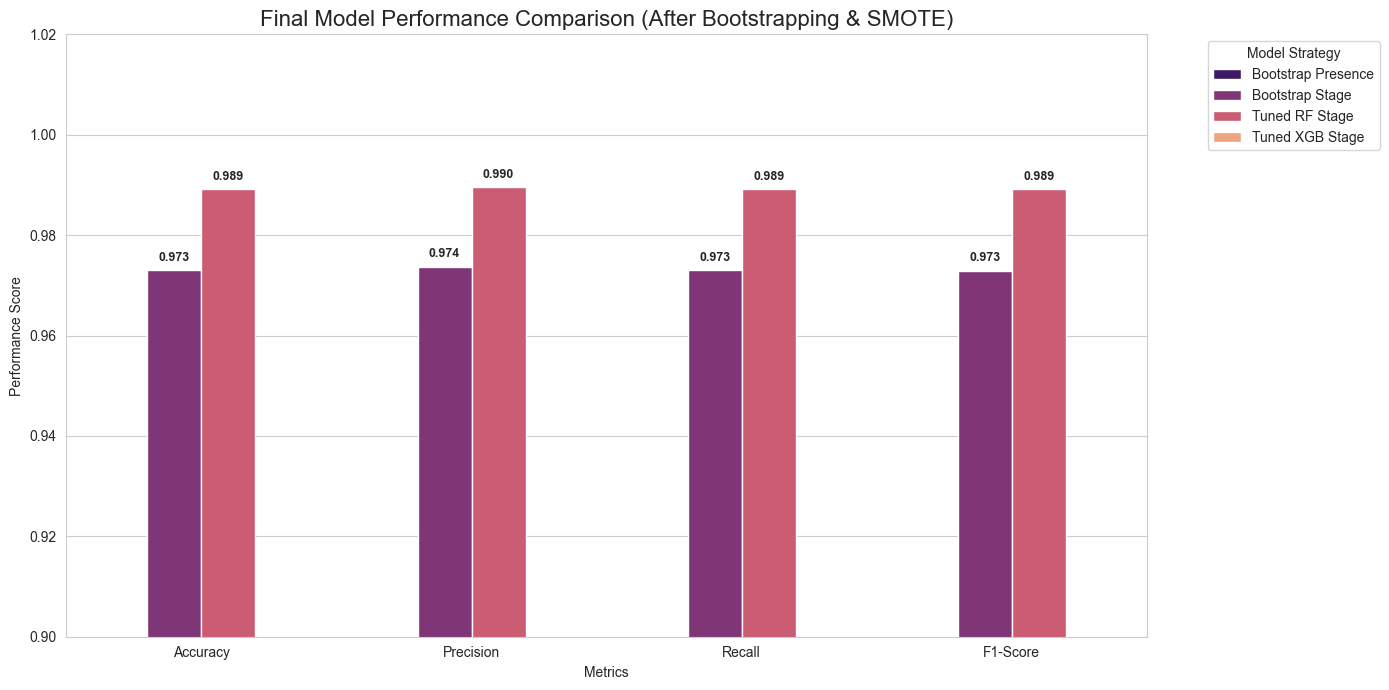

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# 1. Collect metrics for the Bootstrap/Bagging models 
# (Assuming you have run Part A3 and Part B3 from your script)

def get_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    return [acc, prec, rec, f1]

# 2. Creating the Results Dictionary
# These variables match the 'Combo' (Bootstrap + SMOTE) results from your script
final_results = {
    "Metrics": ["Accuracy", "Precision", "Recall", "F1-Score"],
    "Bootstrap Presence": get_metrics(y_test1s, pred_presence_combo),
    "Bootstrap Stage": get_metrics(y_test2s, pred_stage_combo),
    "Tuned RF Stage": get_metrics(y_test2s, pred_stage_smote),  # Standard RF with SMOTE for comparison
    "Tuned XGB Stage": get_metrics(y_test_s, pred_xgb_s)       # Tuned XGB for comparison
}

df_final = pd.DataFrame(final_results)

# 3. Reshape for plotting
df_melted = df_final.melt(id_vars="Metrics", var_name="Model Strategy", value_name="Score")

# 4. Generate the Plot
plt.figure(figsize=(14, 7))
sns.set_style("whitegrid")

# Histogram-based bar chart
ax = sns.barplot(data=df_melted, x="Metrics", y="Score", hue="Model Strategy", palette="magma")

# Add value labels
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.3f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points',
                   fontsize=9, fontweight='bold')

plt.title("Final Model Performance Comparison (After Bootstrapping & SMOTE)", fontsize=16)
plt.ylabel("Performance Score")
plt.ylim(0.90, 1.02) # Zoomed in to show high-performance differences
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Model Strategy")
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [39]:
!pip install lime



 GENERATING SHAP FOR: Migraine Presence


D:\New folder\envs\deep\lib\site-packages\xgboost\core.py:158: UserWarning: [00:45:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model Accuracy: 0.9625
Calculating SHAP values...
✅ Graph saved as: Migraine_Presence_SHAP.png


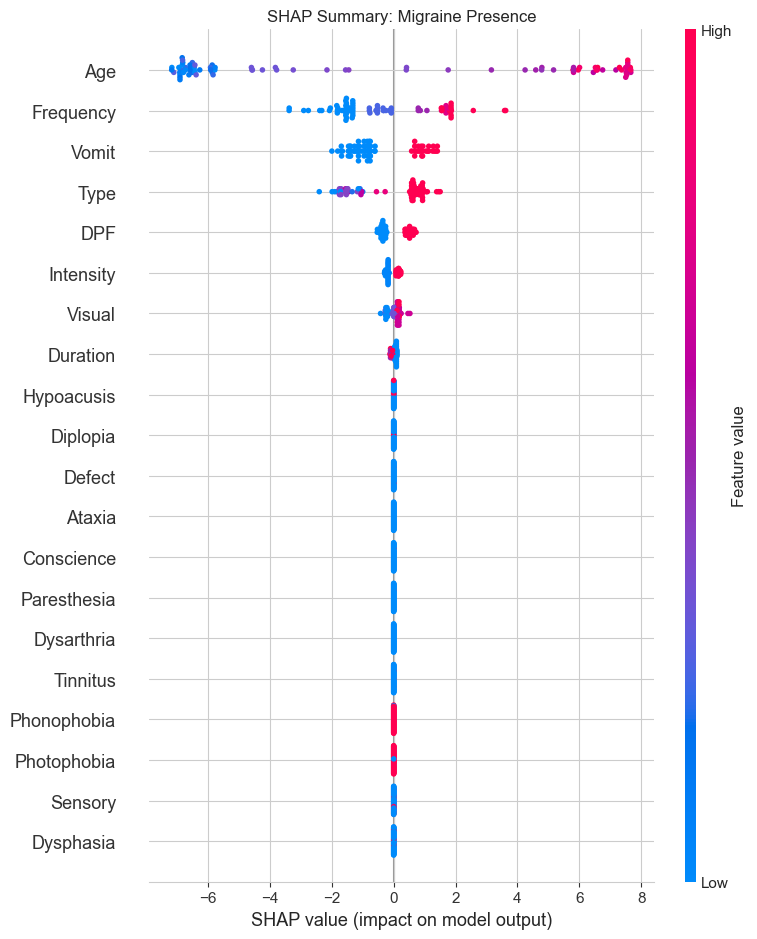


 GENERATING SHAP FOR: Migraine Stage


D:\New folder\envs\deep\lib\site-packages\xgboost\core.py:158: UserWarning: [00:45:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model Accuracy: 0.9250
Calculating SHAP values...
✅ Graph saved as: Migraine_Stage_SHAP.png


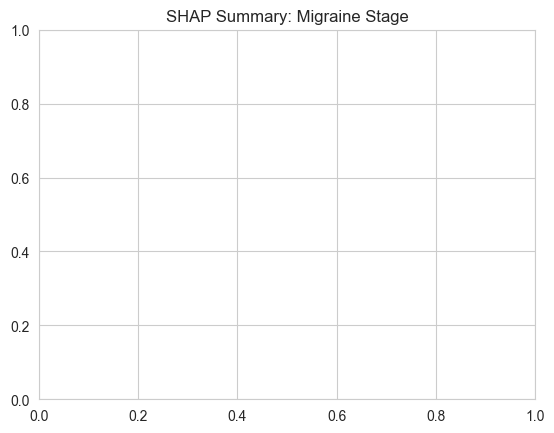

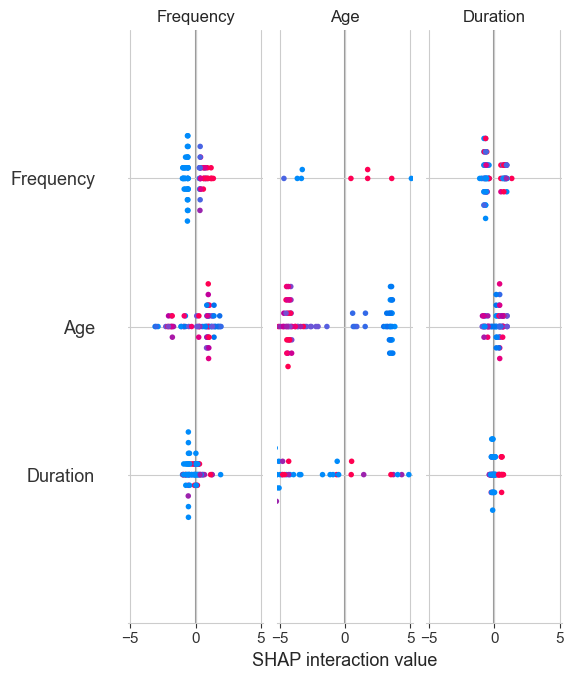

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score

# ==========================================
# 1. LOAD & PREPROCESS DATA
# ==========================================
# Load dataset
df = pd.read_csv("migraine_symptom_classification.csv")

# Handle Missing Values
df = df.dropna(how="all")
df.ffill(inplace=True)

# Encode Categorical Columns
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = LabelEncoder().fit_transform(df[col])

# ==========================================
# 2. DEFINE TARGETS
# ==========================================
# Create targets based on your notebook logic
if "migraine_presence" not in df.columns:
    df["migraine_presence"] = np.where(df.mean(axis=1) > df.mean().mean(), 1, 0)

if "migraine_stage" not in df.columns:
    avg = df.mean(axis=1)
    df["migraine_stage"] = pd.cut(avg,
        bins=[-np.inf, avg.quantile(0.33), avg.quantile(0.66), np.inf],
        labels=[0, 1, 2]
    ).astype(int)

# ==========================================
# FUNCTION: TRAIN & EXPLAIN (SHAP ONLY)
# ==========================================
def explain_with_shap(target_col, task_name):
    print(f"\n{'='*40}")
    print(f" GENERATING SHAP FOR: {task_name}")
    print(f"{'='*40}")

    # Separate Features and Target
    drop_cols = ["migraine_presence", "migraine_stage"]
    X = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')
    y = df[target_col]

    # Split Data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Apply SMOTE (Data Augmentation)
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    # Train XGBoost Model
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    model.fit(X_train_smote, y_train_smote)
    
    print(f"Model Accuracy: {accuracy_score(y_test, model.predict(X_test)):.4f}")

    # ---------------------------
    # SHAP (Global Importance)
    # ---------------------------
    print(f"Calculating SHAP values...")
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    plt.figure()
    plt.title(f"SHAP Summary: {task_name}")
    
    # Check if output is a list (Multiclass) or array (Binary)
    if isinstance(shap_values, list):
        # For Multiclass: This creates a stacked bar chart of feature importance
        shap.summary_plot(shap_values, X_test, show=False)
    else:
        # For Binary: This creates the standard dot plot
        shap.summary_plot(shap_values, X_test, show=False)
        
        # --- SAVE IMAGE COMMAND ---
    filename = f"{task_name.replace(' ', '_')}_SHAP.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight') # Saves high quality image
    print(f"✅ Graph saved as: {filename}")

    plt.show()
    
    plt.show()

# ==========================================
# 3. RUN FOR BOTH TASKS
# ==========================================

# Task 1: Migraine Presence (Binary)
explain_with_shap(target_col="migraine_presence", task_name="Migraine Presence")

# Task 2: Migraine Stage (Multiclass)
explain_with_shap(target_col="migraine_stage", task_name="Migraine Stage")


Generating LIME for Presence...
Saved: lime_presence.png
Generating LIME for Stages...
Saved: lime_stages.png


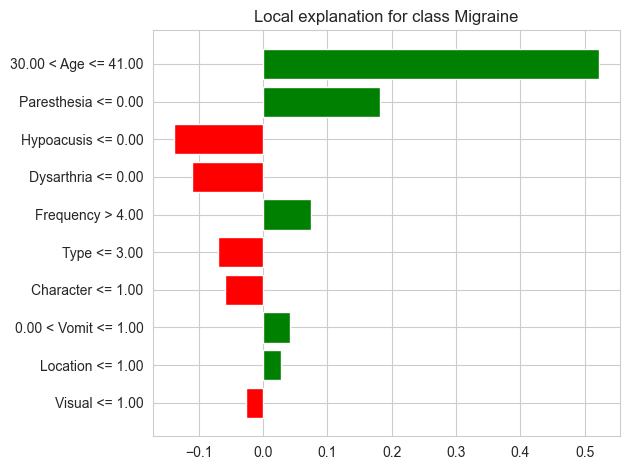

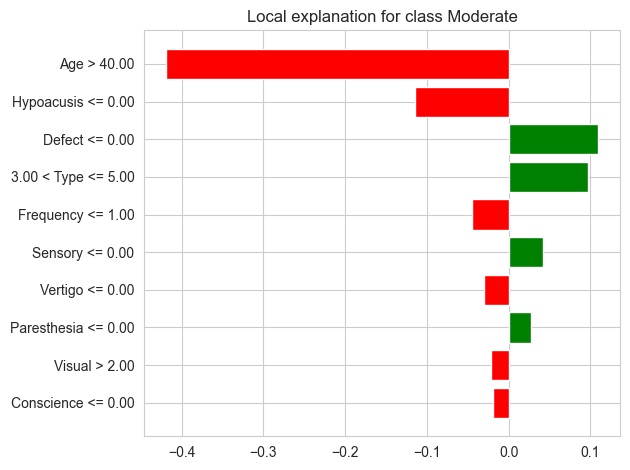

In [57]:
import warnings
import numpy as np
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt # Graph save krnay k liye zaroori library

warnings.simplefilter(action='ignore', category=FutureWarning)

# ======================================================
# PART 1B: Save Presence Graph
# ======================================================
print("Generating LIME for Presence...")

lime_explainer_p = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_p),
    feature_names=list(feats_p),
    class_names=['No Migraine', 'Migraine'],
    mode='classification'
)

idx_p = np.random.randint(0, len(X_test_p))

exp_p = lime_explainer_p.explain_instance(
    data_row=X_test_p.iloc[idx_p].values,
    predict_fn=model_p.predict_proba
)

# --- SAVE AS IMAGE ---
fig_p = exp_p.as_pyplot_figure() # Graph ko figure main convert kia
plt.tight_layout() # Layout set kia ta k text cut na ho
fig_p.savefig('lime_presence.png', dpi=300, bbox_inches='tight') # Save command
print("Saved: lime_presence.png")


# ======================================================
# PART 2B: Save Stages Graph
# ======================================================
print("Generating LIME for Stages...")

lime_explainer_s = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_s),
    feature_names=list(feats_s),
    class_names=['Mild', 'Moderate', 'Severe'],
    mode='classification'
)

idx_s = np.random.randint(0, len(X_test_s))

exp_s = lime_explainer_s.explain_instance(
    data_row=X_test_s.iloc[idx_s].values,
    predict_fn=model_s.predict_proba,
    num_features=10
)

# --- SAVE AS IMAGE ---
fig_s = exp_s.as_pyplot_figure()
plt.tight_layout()
fig_s.savefig('lime_stages.png', dpi=300, bbox_inches='tight')
print("Saved: lime_stages.png")